# Importações

In [1]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import plotly.express as px
import seaborn as sns


# Conexão ao PostgreSQl

In [2]:
user = "avnadmin"
password = "AVNS_9fZb3BkX9qGXxKpxsrZ"
host = "postgresql-iscac.f.aivencloud.com"
port = "25674"
bucket = "Seasonality"

# URL de conexão com PostgreSQL
engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{bucket}')

#Nome da tabela 
meteorology ='meteorology'

# Importar dados do PostgreSQl

In [3]:
try:
    # Ler os dados da tabela no DataFrame
    df = pd.read_sql(f"SELECT * FROM {meteorology}", con=engine)
    
    # Exibir as duas primeiras colunas
    print(df.head())  # Seleciona apenas as duas primeiras colunas e mostra as 5 primeiras linhas
except Exception as e:
    print(f"Erro ao importar os dados: {e}")

             datetime  temp  feelslike   dew  humidity  precip  precipprob  \
0 2021-08-01 00:00:00  17.6       17.6  11.7     68.66     0.0         0.0   
1 2021-08-01 01:00:00  17.4       17.4  12.6     73.22     0.0         0.0   
2 2021-08-01 02:00:00  17.1       17.1  12.7     75.40     0.0         0.0   
3 2021-08-01 03:00:00  17.1       17.1  12.7     75.35     0.0         0.0   
4 2021-08-01 04:00:00  17.0       17.0  12.4     74.52     0.0         0.0   

  preciptype  windgust  windspeed  winddir  sealevelpressure  cloudcover  \
0       None       NaN       25.0    337.0            1020.7         NaN   
1       None       NaN       18.2    338.0            1020.7         NaN   
2       None       NaN       17.9    329.0            1020.0         NaN   
3       None       NaN       11.2    329.0            1019.9         NaN   
4       None       NaN        8.4    349.0            1019.5         NaN   

   visibility conditions                                  stations  
0    

# Visualizar Dados

In [4]:
print(df.dtypes)

datetime            datetime64[ns]
temp                       float64
feelslike                  float64
dew                        float64
humidity                   float64
precip                     float64
precipprob                 float64
preciptype                  object
windgust                   float64
windspeed                  float64
winddir                    float64
sealevelpressure           float64
cloudcover                 float64
visibility                 float64
conditions                  object
stations                    object
dtype: object


In [5]:
print('Com NaN')
print('O ano 2021 tem',df[df['datetime'].dt.year == 2021]['precip'].isna().sum(), 'NaN')
print('O ano 2022 tem', df[df['datetime'].dt.year == 2022]['precip'].isna().sum(), 'NaN')
print('O ano 2023 tem', df[df['datetime'].dt.year == 2023]['precip'].isna().sum(), 'NaN')
print('O ano 2024 tem', df[df['datetime'].dt.year == 2024]['precip'].isna().sum(), 'NaN')
print('')
print('Com valores 0')
print((df[df['datetime'].dt.year == 2021]['precip'] == 0).sum())
print((df[df['datetime'].dt.year == 2022]['precip'] == 0).sum())
print((df[df['datetime'].dt.year == 2023]['precip'] == 0).sum())
print((df[df['datetime'].dt.year == 2024]['precip'] == 0).sum())


Com NaN
O ano 2021 tem 7 NaN
O ano 2022 tem 1311 NaN
O ano 2023 tem 8758 NaN
O ano 2024 tem 8782 NaN

Com valores 0
3457
7190
1
1


# Preenchimento de Valores Ausentes

### 1º Prencher o valor da 1h da manhã em falta

In [6]:
# Para o dia 27
start_time = '2022-03-27 00:00:00'
end_time = '2022-03-27 03:00:00'
df_selected = df[(df['datetime'] >= start_time) & (df['datetime'] <= end_time)]
print(df_selected.dtypes)

# Identificar as colunas numéricas e de texto
numeric_columns = df_selected.select_dtypes(include=['number']).columns
string_columns = df_selected.select_dtypes(include=['object']).columns

# Exibir as colunas para verificação
print(f'Colunas numéricas: {numeric_columns}')
print(f'Colunas de texto: {string_columns}')

# Resample para garantir que temos todas as horas de 00:00 a 03:00 (incluindo 1:00 AM ausente)
df_selected_resampled = df_selected.set_index('datetime').resample('H').asfreq()

# Interpolar para as colunas numéricas
df_selected_resampled[numeric_columns] = df_selected_resampled[numeric_columns].interpolate(method='linear')

# Preencher as colunas de texto de maneira adequada (usando forward fill ou preenchendo com o valor mais frequente)
for col in string_columns:
    # Verificando se há um valor de moda na coluna
    mode_value = df_selected_resampled[col].mode()
    if not mode_value.empty:
        # Se houver, preencher com o valor de moda (o mais frequente)
        df_selected_resampled[col] = df_selected_resampled[col].fillna(mode_value[0])
    else:
        # Caso não haja um valor de moda, usar 'ffill' (preenchendo com o valor anterior)
        df_selected_resampled[col] = df_selected_resampled[col].fillna(method='ffill')

# Resetando o índice para devolver a coluna 'datetime'
df_selected_resampled = df_selected_resampled.reset_index()

# Visualizando os dados após interpolação e preenchimento
print(f"\nDados após interpolação e preenchimento:\n", df_selected_resampled)




datetime            datetime64[ns]
temp                       float64
feelslike                  float64
dew                        float64
humidity                   float64
precip                     float64
precipprob                 float64
preciptype                  object
windgust                   float64
windspeed                  float64
winddir                    float64
sealevelpressure           float64
cloudcover                 float64
visibility                 float64
conditions                  object
stations                    object
dtype: object
Colunas numéricas: Index(['temp', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover',
       'visibility'],
      dtype='object')
Colunas de texto: Index(['preciptype', 'conditions', 'stations'], dtype='object')

Dados após interpolação e preenchimento:
              datetime   temp  feelslike    dew  humidity  precip  precipprob  \
0 2022-03-

C:\Users\joana\AppData\Local\Temp\ipykernel_19868\2692349339.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_selected_resampled = df_selected.set_index('datetime').resample('H').asfreq()
C:\Users\joana\AppData\Local\Temp\ipykernel_19868\2692349339.py:30: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_selected_resampled[col] = df_selected_resampled[col].fillna(method='ffill')


### 2º Prencher os dados em falta do dia 17 de março 2023

In [7]:

# Filtrar o DataFrame 
start_time = '2023-03-17 00:00:00'
end_time = '2023-03-17 07:00:00'

# Filtrar os dados no intervalo de tempo desejado
df_selected = df[(df['datetime'] >= start_time) & (df['datetime'] <= end_time)]

# Verifique os valores ausentes no período selecionado
print(df_selected.isna().sum())


datetime            0
temp                8
feelslike           8
dew                 8
humidity            8
precip              8
precipprob          8
preciptype          8
windgust            8
windspeed           8
winddir             8
sealevelpressure    8
cloudcover          8
visibility          8
conditions          8
stations            8
dtype: int64


In [8]:

start_time = '2023-03-17 00:00:00'
end_time = '2023-03-17 07:00:00'
df_selected = df[(df['datetime'] >= start_time) & (df['datetime'] <= end_time)]

# Filtrar os dados do dia anterior (16 de março de 2023) entre 00:00 e 07:00
previous_day_start = '2023-03-16 00:00:00'
previous_day_end = '2023-03-16 07:00:00'
df_previous_day = df[(df['datetime'] >= previous_day_start) & (df['datetime'] <= previous_day_end)]

# Filtrar os dados do dia seguinte (18 de março de 2023) entre 00:00 e 07:00
next_day_start = '2023-03-18 00:00:00'
next_day_end = '2023-03-18 07:00:00'
df_next_day = df[(df['datetime'] >= next_day_start) & (df['datetime'] <= next_day_end)]

# Exibir os valores dos 3 dias (anterior, selecionado, seguinte)
print(f'Valores do dia anterior (16 de março de 2023):\n', df_previous_day)
print(f'\nValores do dia selecionado (17 de março de 2023, 00:00-07:00):\n', df_selected)
print(f'\nValores do dia seguinte (18 de março de 2023):\n', df_next_day)

# Comparar as médias dos dias anterior e seguinte para ver se são semelhantes
mean_previous_day = df_previous_day.mean(numeric_only=True)
mean_next_day = df_next_day.mean(numeric_only=True)

print(f'\nMédia do dia anterior (16 de março de 2023, 00:00-07:00):\n', mean_previous_day)
print(f'\nMédia do dia seguinte (18 de março de 2023, 00:00-07:00):\n', mean_next_day)

# Comparar as médias entre os dias
similarity = mean_previous_day - mean_next_day
print(f'\nDiferença entre as médias do dia anterior e do dia seguinte:\n', similarity)

# Verifique se a diferença nas médias é pequena para decidir se vai preencher os dados
threshold = 0.1  # Um valor de limiar que você considera aceitável para as médias serem semelhantes
if similarity.abs().max() < threshold:
    print('\nAs médias são semelhantes o suficiente para preencher os dados ausentes com esses valores.')
else:
    print('\nAs médias são muito diferentes. É melhor considerar outro método de preenchimento.')



Valores do dia anterior (16 de março de 2023):
                  datetime  temp  feelslike  dew  humidity  precip  precipprob  \
12370 2023-03-16 00:00:00  11.0       11.0  8.0     81.75     NaN         0.0   
12371 2023-03-16 01:00:00  10.0       10.0  8.0     87.38     NaN         0.0   
12372 2023-03-16 02:00:00  10.0       10.0  9.0     93.50     NaN         0.0   
12373 2023-03-16 03:00:00  11.0       11.0  9.0     87.48     NaN         0.0   
12374 2023-03-16 04:00:00  11.0       11.0  8.0     81.75     NaN         0.0   
12375 2023-03-16 05:00:00   9.0        9.0  8.0     93.45     NaN         0.0   
12376 2023-03-16 06:00:00   9.0        9.0  8.0     93.45     NaN         0.0   
12377 2023-03-16 07:00:00   8.0        8.0  8.0    100.00     NaN         0.0   

      preciptype  windgust  windspeed  winddir  sealevelpressure  cloudcover  \
12370       None       NaN        0.0      NaN            1013.0         NaN   
12371       None       NaN        0.0      0.0            1013

# Analises 

### Para Temperatura

In [9]:
# Definir as estaçôes do ano
def get_season(date):
    if date.month in [12, 1, 2]:
        return 'Winter'
    elif date.month in [3, 4, 5]:
        return 'Spring'
    elif date.month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

In [10]:
# Função para criar boxplot para temperatura por estações
def plot_temperature_by_season(df):
    df['season'] = df['datetime'].map(get_season)

    palette = sns.color_palette('coolwarm', 4)  # Gera 4 cores da paleta coolwarm
    palette[2], palette[3] = palette[3], palette[2]   # Substitui a cor do verão pela cor do outono (índice 2 = verão, índice 3 = outono)

    # Criar o boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='season', y='temp', data=df, order=['Winter', 'Spring', 'Summer', 'Autumn'], palette=palette)
    plt.title('Temperature Distribution by Season')
    plt.xlabel('Season')
    plt.ylabel('Temperature (°C)')
    plt.grid(alpha=0.3)
    plt.show()

C:\Users\joana\AppData\Local\Temp\ipykernel_19868\1348530184.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='season', y='temp', data=df, order=['Winter', 'Spring', 'Summer', 'Autumn'], palette=palette)


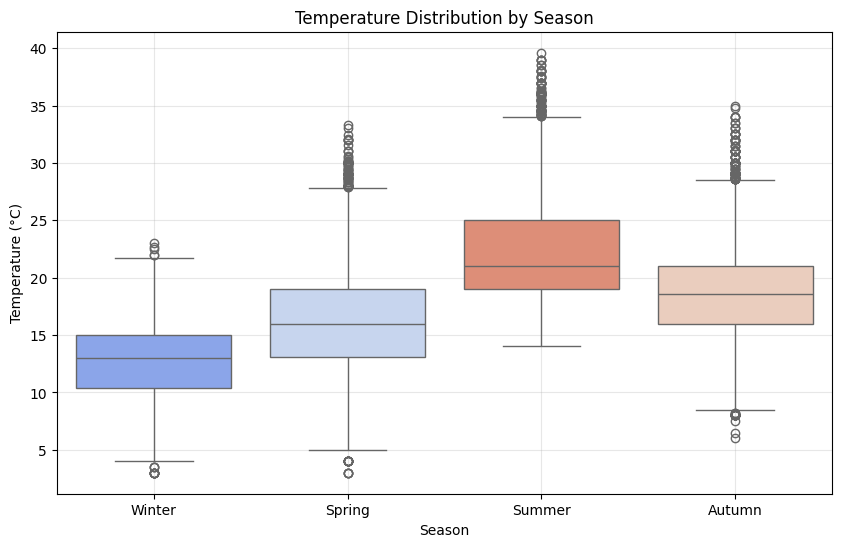

In [11]:
plot_temperature_by_season(df)

C:\Users\joana\AppData\Local\Temp\ipykernel_19868\1348530184.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['season'] = df['datetime'].map(get_season)
C:\Users\joana\AppData\Local\Temp\ipykernel_19868\1348530184.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='season', y='temp', data=df, order=['Winter', 'Spring', 'Summer', 'Autumn'], palette=palette)


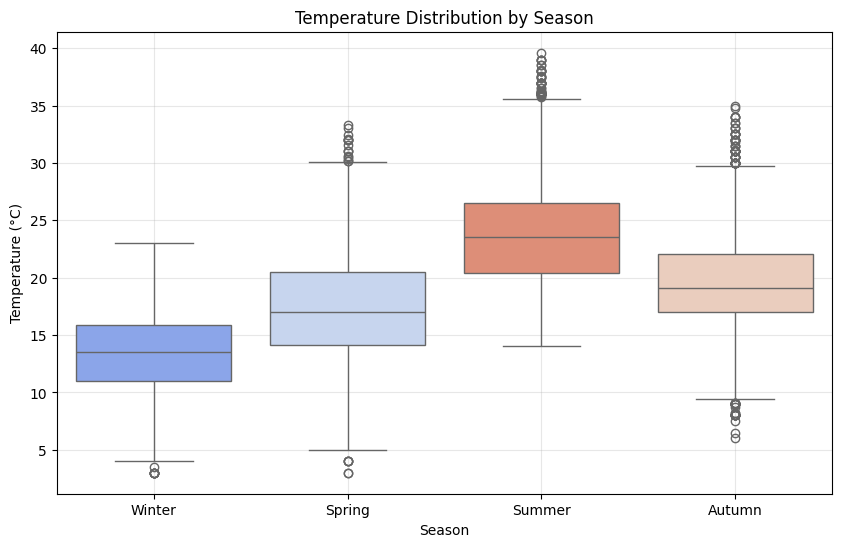

In [12]:
# extrair a noite para ver se há uma diferença, sendo que as temperaturas a noite no verão são frias. 

df['hour'] = df['datetime'].dt.hour  # Extrai a hora da coluna datetime
df_filtered = df[(df['hour'] >= 6) & (df['hour'] <= 20)]  # Filtra entre 6h da manhã e 20h

plot_temperature_by_season(df_filtered)


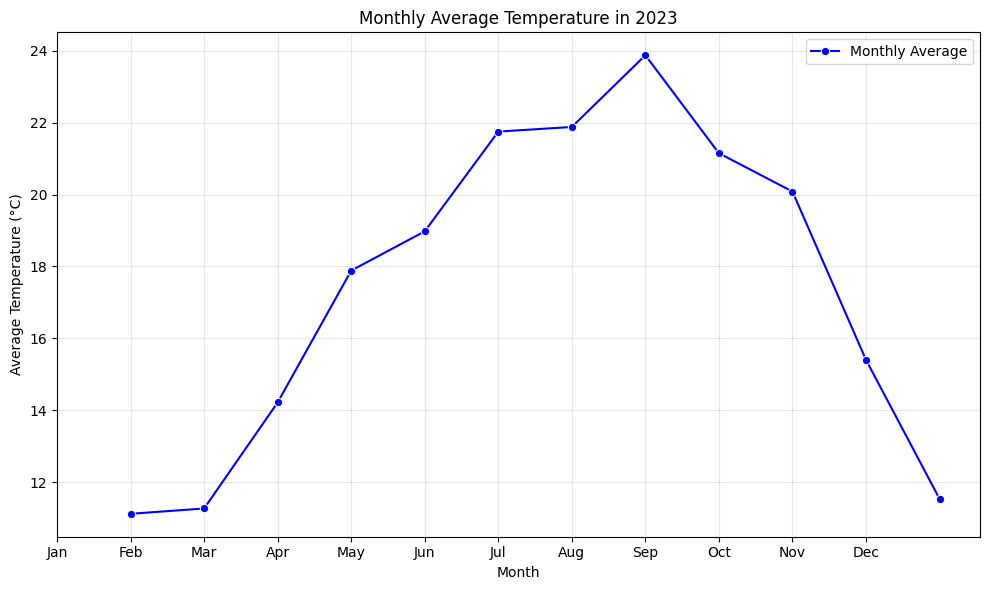

In [13]:
#Gráfico da temperatura média por mês do ano pretendido
# Extrair o ano e o mês da coluna datetime
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month

# Filtrar os dados para um ano específico
year_to_filter = 2023  # Defina o ano desejado aqui
df_filtered = df[df['year'] == year_to_filter]

# Calcular a temperatura média por mês
monthly_avg_temp = df_filtered.groupby(['month'])['temp'].mean().reset_index()

plt.figure(figsize=(10, 6))

# Gráfico de linha para a temperatura média mensal
sns.lineplot(x='month', y='temp', data=monthly_avg_temp, marker='o', color='b', label='Monthly Average')
plt.title(f'Monthly Average Temperature in {year_to_filter}')
plt.xlabel('Month')
plt.ylabel('Average Temperature (°C)')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [23]:

df_2021 = df[df["datetime"].dt.year == 2022].copy()

# Faz a média diária da temperatura
df_2021_diario = df_2021.groupby(df_2021["datetime"].dt.date)["temp"].mean().reset_index()
df_2021_diario["datetime"] = pd.to_datetime(df_2021_diario["datetime"])  # Converter para datetime novamente

# Calcula a variação da temperatura diária
df_2021_diario["var_temp"] = df_2021_diario["temp"].diff()

# Identifica mudanças de tendência (subida -> descida ou vice-versa)
df_2021_diario["mudanca"] = np.sign(df_2021_diario["var_temp"]) != np.sign(df_2021_diario["var_temp"].shift())

# Cria um identificador único para cada segmento de tendência
df_2021_diario["segmento"] = df_2021_diario["mudanca"].cumsum()



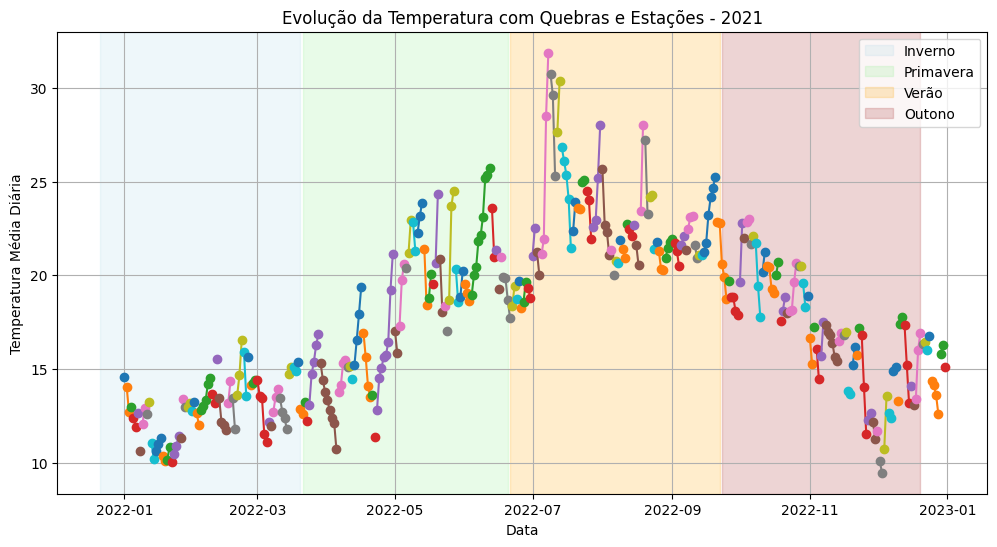

In [25]:
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))

# Define as datas de início das estações (ajustar conforme hemisfério)
seasons = {
    "Inverno": ["2021-12-21", "2022-03-20"],
    "Primavera": ["2022-03-21", "2022-06-20"],
    "Verão": ["2022-06-21", "2022-09-22"],
    "Outono": ["2022-09-23", "2022-12-20"]
}

colors = {"Inverno": "lightblue", "Primavera": "lightgreen", "Verão": "orange", "Outono": "brown"}

# Adiciona faixas para cada estação
for season, (start, end) in seasons.items():
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color=colors[season], alpha=0.2, label=season)

# Plota as tendências por segmento
for _, segmento in df_2021_diario.groupby("segmento"):
    plt.plot(segmento["datetime"], segmento["temp"], marker="o")

plt.xlabel("Data")
plt.ylabel("Temperatura Média Diária")
plt.title("Evolução da Temperatura com Quebras e Estações - 2021")
plt.legend()
plt.grid()
plt.show()


### Para a Percipitação

In [12]:
# Função para criar um boxplot para precipitação por estação
def plot_precipitation_by_season(df,start_date, end_date):
     df_filtered = df[(df['datetime'] >= pd.to_datetime(start_date)) & (df['datetime'] <= pd.to_datetime(end_date))]

    # Criar uma nova coluna 'season' com as estações
     df_filtered['season'] = df_filtered['datetime'].apply(get_season)

    # Definir a paleta de cores
     palette = sns.color_palette('coolwarm', 4)
     palette[2], palette[3] = palette[3], palette[2]

    # Criar o boxplot
     plt.figure(figsize=(10, 6))
     sns.boxplot(x='season', y='precip', data=df_filtered, order=['Winter', 'Spring', 'Summer', 'Autumn'], palette=palette)
     plt.title('Precipitation Distribution by Season')
     plt.xlabel('Season')
     plt.ylabel('Precipitation (mm)')
     plt.grid(alpha=0.3)
     plt.show()



C:\Users\joana\AppData\Local\Temp\ipykernel_14980\3689468042.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['season'] = df_filtered['datetime'].apply(get_season)
C:\Users\joana\AppData\Local\Temp\ipykernel_14980\3689468042.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='season', y='precip', data=df_filtered, order=['Winter', 'Spring', 'Summer', 'Autumn'], palette=palette)


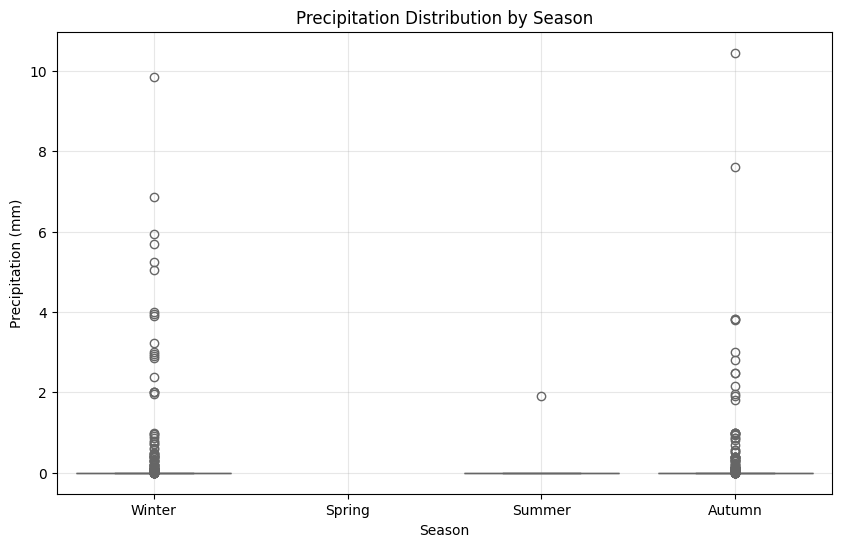

In [13]:
s_date = "2021-01-01"
e_date = "2021-12-31"
plot_precipitation_by_season(df,s_date, e_date)

In [14]:
# o outlier maior em outono (parece a ser um outlier falso, não encontro noticias sobre este dia)
# Filtrar apenas o outono
autumn_data = df[df['season'] == 'Autumn']

# Encontrar o maior valor de precipitação
outlier_day = autumn_data[autumn_data['precip'] == autumn_data['precip'].max()]
print(outlier_day)


                 datetime  temp  feelslike   dew  humidity  precip  \
22051 2022-10-11 13:00:00  22.5       22.5  18.4     77.77    52.0   

       precipprob preciptype  windgust  windspeed  winddir  sealevelpressure  \
22051       100.0       rain       NaN       10.7     50.0            1019.1   

       cloudcover  visibility              conditions  \
22051        27.5        10.0  Rain, Partially cloudy   

                           stations  season  hour  
22051  08535099999,08536099999,LPPT  Autumn    13  


In [15]:
# Função para criar gráfico de barras para percipitação por estações

def plot_precipitation_bars(df,start_date, end_date):
    df_filtered = df[(df['datetime'] >= pd.to_datetime(start_date)) & (df['datetime'] <= pd.to_datetime(end_date))]

    # Criar coluna 'season' e remover linhas com valores NaN
    df_filtered['season'] = df_filtered['datetime'].apply(get_season)
    df_filtered = df_filtered.dropna(subset=['precip', 'season'])

    seasons = ['Winter', 'Spring', 'Summer', 'Autumn']

    # Calcular média e mediana para cada estação dentro do intervalo
    means = [df_filtered[df_filtered['season'] == season]['precip'].mean() for season in seasons]
    medians = [df_filtered[df_filtered['season'] == season]['precip'].median() for season in seasons]

    # Configuração do gráfico de barras
    x = np.arange(len(seasons))  # Posições no eixo X
    bar_width = 0.35  # Largura das barras

    plt.figure(figsize=(10, 6))
    plt.bar(x - bar_width/2, means, bar_width, label='Mean', color='red')
    plt.bar(x + bar_width/2, medians, bar_width, label='Median', color='black')

    plt.title(f'Precipitation Mean and Median by Season\n({start_date} to {end_date})')
    plt.xlabel('Season')
    plt.ylabel('Precipitation (mm)')
    plt.xticks(x, seasons)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


C:\Users\joana\AppData\Local\Temp\ipykernel_14980\1181220394.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['season'] = df_filtered['datetime'].apply(get_season)


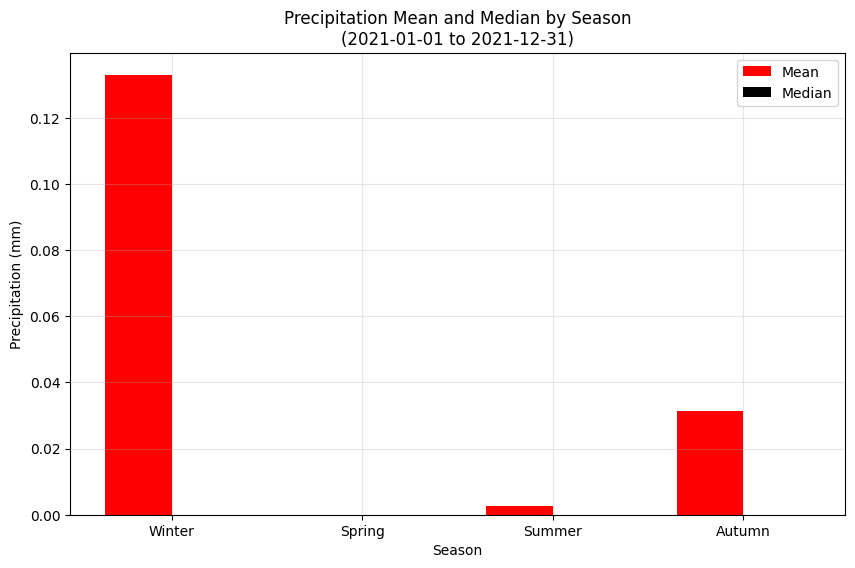

In [16]:
s_date = "2021-01-01"
e_date = "2021-12-31"
plot_precipitation_bars(df,s_date,e_date)

In [17]:
ano_especifico = 2022
# Filtrar o DataFrame para o ano específico
df_ano = df[df['datetime'].dt.year == ano_especifico]  

print(df_ano.groupby('season')['precip'].agg(['mean', 'median']))

# Pode-se ver que a mediana é zéro. é por isso que não aparace no gráfico em cima. 
# Como a mediana é menos sensível a valores extremos, se houver muitos dias secos e poucos dias com chuva intensa, a mediana pode ser zero ou próxima de zero


            mean  median
season                  
Autumn  0.119107     0.0
Spring  0.065782     0.0
Summer  0.003657     0.0
Winter  0.008245     0.0


In [43]:
ano_especifico = 2021  # Substitua pelo ano que deseja analisar

# Filtrar o DataFrame para o ano específico
df_ano = df[df['datetime'].dt.year == ano_especifico]  

# Contar o total de dias no ano
total_days_ano = len(df_ano)

# Contar os dias sem chuva (precipitação = 0)
dry_days_ano = len(df_ano[df_ano['precip'] == 0])

# Calcular a percentagem de dias sem chuva no ano específico
percentage_dry_days_ano = (dry_days_ano / total_days_ano) * 100

print(f"Percentagem de dias sem chuva em {ano_especifico}: {percentage_dry_days_ano:.2f}%")


Percentagem de dias sem chuva em 2021: 94.14%
